# ai-cloud-computing

## Introduction <br>

The very young AgriTech start-up, named “**Fruits**!”,
seeks to offer innovative solutions for fruit harvesting.

The company's desire is to preserve the biodiversity of fruits
by allowing specific treatments for each species of fruit
by developing intelligent picking robots.

The start-up initially wishes to make itself known by putting
available to the general public a mobile application which would allow
users to take a photo of a fruit and get information about that fruit.

For the start-up, this application would raise awareness among the general public
to fruit biodiversity and to set up a first version of the engine
classification of fruit images.

In addition, the development of the mobile application will make it possible to build
a first version of the **Big Data** architecture required.

## Objectives in this project

1. Develop a first data processing chain that <br />
   will include **preprocessing** and a **dimension reduction** step.
2. Take into account that <u>the volume of data will increase <br />
   very quickly</u>after delivery of this project, which involves:
 - Deploy data processing in a **Big Data** environment
 - Develop scripts in **pyspark** to perform **distributed computing**

## Technical choices <br>
We must take into account the very rapid increase in the volume of data after delivery of the project. This is why it is important to introduce a distributed calculation methodology upstream. To do this we will create **pyspark** scripts. <br>
**pySpark** is a way to communicate
with **Spark** via the **Python** language.<br />
**Spark**, for its part, is a tool that allows you to manage and coordinate
performing tasks on data across a group of computers. <br />
<u>Spark (or Apache Spark) is an open source distributed computing framework <br />
in-memory for processing and analyzing massive data</u>.

![Schéma de Spark](img/spark-schema.png)

*The driver (sometimes called “Spark Session”) distributes and schedules
the tasks between the different executors which execute them and allow
distributed processing. He is responsible for executing the code
on the different machines.

Each executor is a separate Java Virtual Machine (JVM) process<br />
of which it is possible to configure the number of CPUs and the quantity of
memory allocated to it. <br />
Only one task can process one data split at a time.*

In both environments (Local and Cloud) we will therefore use **Spark**
and we will exploit it through python scripts using **PySpark**.

In the <u>local version</u> of our script we **simulate
distributed computing** in order to validate that our solution works.<br />
In the <u>cloud version</u> we **perform operations on a machine cluster**.

## Transfert Learning

**Transfer learning** consists of
to use the knowledge already acquired
by a trained model (here **MobileNetV2**) for
adapt it to our problem.

We're going to provide the model with our images, and we're going to
<u>recover the penultimate layer</u> of the model.
Indeed the last model layer is a softmax layer
which allows the classification of images which we do
we do not want in this project.

The penultimate layer corresponds to a **vector
reduced** in dimension (1,1,1280).

This will make it possible to create a first version of the engine
for classification of fruit images.

**MobileNetV2** was selected for its <u>speed of execution</u>,
particularly suitable for processing a large volume
of data as well as the <u>low dimensionality of the vector
of output characteristic</u> (1,1,1280)

## Working environment

We carried out this project on a macOS operating system. <br>
Its installation is quickly explained in order to have a memory aid for later use.<br>
<br>

```bash
brew install openjdk@11
brew install python
brew install apache-spark
```  

Add Spark to the environment variables by adding the following lines to your <br>
.bash_profile, .zshrc or equivalent depending on your shell: <br>

```bash
export SPARK_HOME=/usr/local/spark
export PATH=$SPARK_HOME/bin:$PATH
```  
<br>
Reload your shell configuration file: <br>

```bash
source ~/.zshrc  # or source ~/.bash_profile
```  

#### If you have trouble with <u>Error: Heap size Spark</u> : <br>

```bash
sudo code /usr/local/Cellar/apache-spark/3.5.1/libexec/conf/spark-defaults.conf
```  
and add :

```bash
spark.driver.memory 15g
spark.driver.maxResultSize 2g
``` 

## 1. Library Import

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.feature import PCA
from PIL import Image
import numpy as np
import io
import os
from pyspark.sql.functions import element_at, split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd

2024-05-31 11:21:00.840497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Setting PATHs to load images and save results

In this local version we assume that the data
are stored in the same directory as the notebook.<br />
We only use an extract of **300 images** to process in this
first version locally.<br />
The extract of images to load is stored in the **Sample** folder.<br />
We will record the result of our treatment
in the "**Results_Local**" folder.

In [2]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Sample2'
PATH_Result = PATH+'/data/results'

In [3]:
PATHX = '/ai-cloud-computing-spark/train'
PATH_DataX = PATHX+'/data/Sample'
PATH_ResultX = PATHX+'/data/results'
print('PATH:        '+\
      PATHX+'\nPATH_Data:   '+\
      PATH_DataX+'\nPATH_Result: '+PATH_ResultX)

PATH:        /ai-cloud-computing-spark/train
PATH_Data:   /ai-cloud-computing-spark/train/data/Sample
PATH_Result: /ai-cloud-computing-spark/train/data/results


## 3. Creating the SparkSession

The Spark application is controlled using a driver process called **SparkSession**. <br />
<u>A **SparkSession** instance is how Spark executes user-defined functions <br />
throughout the cluster</u>. <u>A SparkSession always corresponds to a Spark application</u>. <br>

To avoid session creation bugs we stop all previously created sessions. <br>

<u>Here we create a spark session by specifying in order</u>:
 1. a **name for the application**, which will be displayed in the Spark web UI "**P8**"
 2. that the application must run **locally**. <br />
   We don't define the number of cores to use (like .master('local[4]) for 4 cores to use), <br />
   so we will use all available cores in our processor.<br />
 3. an additional configuration option allowing the use of the **"parquet" format** <br />
   which we will use to save and load the result of our work.
 4. want to **get an existing spark session** or if none exist, create a new one

In [4]:
if SparkSession.builder.getOrCreate().sparkContext:
    SparkSession.builder.getOrCreate().sparkContext.stop()
    
spark = (SparkSession
             .builder
             .appName('ai-cloud-computing-spark')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/31 11:21:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>We also create the variable "**sc**" which is a **SparkContext** from the variable **spark**</u>:

In [5]:
sc = spark.sparkContext

<u>Displaying Spark information while running</u>:

In [6]:
spark

### 4. Loading data

Images are loaded in binary format, which offers,
more flexibility in how to preprocess images. <br>
Before loading the images we specify that we want to load
only files with **jpg** extension. <br>
We also indicate to load all possible objects contained
in the subfolders of the communicated folder.

<u>Display of the first images containing</u>:
 - the image path
 - the date and time of its last modification
 - its length
 - its content encoded in hexadecimal value
 - its label

In [7]:
df = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)
df = df.withColumn('label', element_at(split(df['path'], '/'),-2))
df.show()

+--------------------+--------------------+------+--------------------+--------------+
|                path|    modificationTime|length|             content|         label|
+--------------------+--------------------+------+--------------------+--------------+
|file:/Users/gaeld...|2024-05-30 16:56:...|  4800|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4792|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4778|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4774|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4773|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4766|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4743|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|  4727|[FF D8 FF E0 00 1...|Apple Braeburn|
|file:/Users/gaeld...|2024-05-30 16:56:...|

<u>Data type for each column in the Spark Dataframe</u> <br>

- path: Character string (can be null)
- modificationTime: Timestamp (can be null)
- length: Long integer (can be null)
- content: Binary data (can be null)
- label: Character string (can be null)

In [8]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



## 5.1 PCA

In the introduction, we presented our main goal of reducing feature size. <br>
One method we can test is using PCA on images. <br>
<br>
The Spark documentation tells us that PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)) is only possible on dense vectors or sparse vectors. <br>
- Dense Vector: explicitly stores all its elements.
- Sparse Vector: stores only non-zero elements and their indices

PCA are very slow with Spark, to know the number of main components to keep in our training we carry out a PCA <br> in another notebook to visualize how many PCAs we will keep.

#### <u>We can see, cummulative variance can be explain by only 31 components.</u>

![PCA Graph](img/PCA_grap.png)

When we use these 31 components the image is simplified to improve the model's understanding of the features. <br>
Here is a visualization of the original image and the image simplified by 31 components. <br>

![simplified Image](img/simplified_image.png)

## 5.2 PCA Spark

We now know the number of features suitable for dimension reduction that we can apply with Spark. <br>
For this we must carry out a transformation of the images into a dense vector. <br>
We recover the binary values ​​of the images in a numpy array using cv2 then we apply a dense vector transformation in a new column.

In [9]:
from pyspark.ml.feature import PCA
import cv2
from pyspark.ml.linalg import Vectors, VectorUDT

def image_to_vector(content):
    nparr = np.frombuffer(content, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    img_vector = img.flatten().astype(float)
    return Vectors.dense(img_vector)

image_to_vector_udf = udf(image_to_vector, VectorUDT())
df = df.withColumn('features', image_to_vector_udf(df['content']))

We can check the dense vector transformation.

In [10]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



From the dense vector we can recreate the original image to verify that the transformation worked correctly.

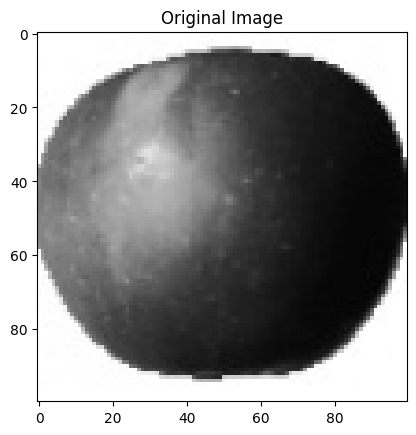

In [11]:

first_row = df.select("features").first()
dense_vector = first_row["features"]
dense_array = dense_vector.toArray()

image_size = (100, 100)
original_image = dense_array.reshape(image_size)

plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.show()

We can now train the PCA to determine which components best explain the variance and apply dimension reduction with the number of principal components we determined previously.

In [142]:
pca = PCA(k=31, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

**We can see the Dataframe with the fresh PCA features extract from binary image.**

In [143]:
result = model.transform(df)
result = result.select(["path", "modificationTime", "label", "pcaFeatures"])
result.show()

24/05/30 19:17:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+--------------------+--------------------+--------------+--------------------+
|                path|    modificationTime|         label|         pcaFeatures|
+--------------------+--------------------+--------------+--------------------+
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-160.07270585257...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-107.69203081395...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-3519.4402560093...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-3338.9699735139...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-92.561565573560...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-3442.6295036906...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-3403.9927280454...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-3467.1368890374...|
|file:/Users/gaeld...|2024-05-30 16:56:...|Apple Braeburn|[-2507.8893136319...|
|file:/Users/gaeld...|2024-05-30 16:56:.

In [147]:
result.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- label: string (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [153]:
pca_first = result.select("pcaFeatures").first()
pca_first

Row(pcaFeatures=DenseVector([-160.0727, -106.7925, -2533.0446, -740.4669, 223.1111, 430.6482, -91.3126, 439.9899, 409.773, 187.3731, -87.5883, 305.7749, -84.6413, 241.7599, -203.1456, -28.9916, -39.7813, -59.588, -66.833, -358.1526, 317.1106, 38.174, -124.3107, 266.934, -332.5095, 207.2177, -122.9711, -240.1571, -505.0819, 254.6341, 101.6733]))

We managed to extract the most relevant features for the classification of our images using PCA using Spark. <br> 
This method seems relevant and makes it easy to determine the most determining characteristics of the images.

## 6. Transfer Learning

Here, we will use the **transfer learning** technique to extract features from images.<br />
We chose to use the **MobileNetV2** model for its comparative speed of execution
to other models like *VGG16* for example.

To learn more about the design and operation of MobileNetV2,
We invite you to read [this article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Here is the diagram of its overall architecture</u>:

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

There is a final layer which is used to classify the images
according to 1000 categories that we don't want to use.<br/>
The idea in this project is to recover the **feature vector
of dimensions (1,1,1280)** which will be used, later, through a motor <br />
classification to recognize the different fruits of the dataset.

Like other similar models, **MobileNetV2**, when used
by including all its layers, necessarily expects images
of dimension (224,224.3). Our images are all of dimension (100,100,3),
we'll just have to **resize** them before handing them over to the model.

<u>In order</u>:
 1. We load the **MobileNetV2** model with the **precalculated** weights <br />
    from **imagenet** and specifying the format of our input images
 2. We create a new model with:
  - <u>input</u>: the input of the MobileNetV2 model
  - <u>output</u>: before last layer of the MobileNetV2 model

In [15]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [16]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Showing the summary of our new model where we see <br />
that <u>we recover as output a vector of dimension (1, 1, 1280)</u>:

In [14]:
model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

All workers must be able to access the model and its weights. <br />
A good practice is to load the model on the driver then broadcast <br />
then the weights for the different workers.

In [17]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [33]:
brodcast_weights.value[0][0][0][0]

array([-1.71659231e-01, -3.33731920e-01,  5.30122258e-02, -5.93232973e-21,
        2.08742931e-01, -1.20433941e-01,  1.75700430e-02, -3.10708203e-22,
       -9.62498877e-03,  1.90229788e-01, -3.67278278e-01,  3.95997976e-22,
       -2.36236629e-22,  3.36706383e-22,  8.83555040e-02, -7.75416642e-02,
        3.95842289e-05, -3.63377742e-02,  5.99925742e-02,  5.53736472e-21,
       -4.68022423e-04, -1.23387486e-01, -1.34351701e-01,  8.75968020e-03,
       -2.47503355e-01,  1.58492010e-02, -2.43145856e-04, -1.09811597e-01,
        5.55126644e-22, -2.03368161e-03,  2.83311605e-01,  7.66634047e-02],
      dtype=float32)

<u>Let's put this in function form</u>:

In [34]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

## 7. Definition of the image loading process and application of their featurization through the use of pandas UDF

This notebook defines the logic in stages, up to Pandas UDF.

<u>The stacking of calls is as follows</u>:

- Pandas UDF
  - featurize a series of pd.Series images
   - preprocess an image

In [35]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Applications/anaconda3/envs/test-spark/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## 8. Executing feature extraction actions

Pandas UDF, on large recordings (e.g. very large images),
may encounter Out Of Memory (OOM) errors.<br />
If you encounter such errors in the cell below,
try reducing Arrow batch size via 'maxRecordsPerBatch'

We will not use this command in this project
and we therefore leave the order in comments.

In [36]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

We can now run featurization across our entire Spark DataFrame.<br />
<u>NOTE</u>: This can take a long time, depending on the volume of data to be processed. <br />

Our **Test** dataset contains **22819 images**. <br />
However, in **local** mode execution,
we <u>will process a reduced set of **330 images**</u>.

In [37]:
features_df = df.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Reminder of the PATH where the files in "**parquet**" format will be written
containing our results, namely, a DataFrame containing 3 columns</u>:
 1. Image path
 2. Image label
 3. Image feature vector

In [38]:
print(PATH_ResultX)

/ai-cloud-computing-spark/train/data/results


<u>Saving processed data in "**parquet**" format</u>:

In [39]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2024-05-31 11:37:38.277227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step1) / 20]


## 9. Loading recorded data and validating the result

<u>We load the freshly recorded data into a **Pandas DataFrame**</u>:

In [40]:
df_X = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>We display the first 5 lines of the DataFrame</u>:

In [41]:
df_X.head()

,path,label,features
0,file:/Users/gaeldelescluse/Documents/OpenClass...,Apple Braeburn,"[0.62744355, 0.01801703, 0.0, 0.0, 0.052694213..."
1,file:/Users/gaeldelescluse/Documents/OpenClass...,Apple Braeburn,"[0.684452, 0.0, 0.0, 0.0, 0.0, 0.9820809, 0.11..."
2,file:/Users/gaeldelescluse/Documents/OpenClass...,Apple Braeburn,"[0.47713244, 0.009235304, 0.0, 0.0, 0.05071613..."
3,file:/Users/gaeldelescluse/Documents/OpenClass...,Apple Braeburn,"[0.8886882, 0.04125667, 0.0, 0.0, 0.03716972, ..."
4,file:/Users/gaeldelescluse/Documents/OpenClass...,Apple Braeburn,"[0.41573045, 0.019337235, 0.0, 0.0, 0.0, 0.823..."
